In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd
import glob
import matplotlib.ticker as mticker
import json

from scipy.io import loadmat
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

## Defining Constants

In [8]:
'''
Defining the constants
'''
method_name_list = [
    'nvdiffrecmc_pseudo_gt', 'nvdiffrec_pseudo_gt', 'idr', 
    'nerf', 'neuralpil', 'physg', 'nvdiffrec', 'nerd', 
    'invrender', 'nvdiffrecmc', 'singleimage', 'sirfs'
    # <---- Add your method's name here ----> #
]

rename_method_dict = {
    'nerd':'NeRD',
    'nvdiffrec':"NVDiffRec",
    'nvdiffrecmc':'NVDiffRecMC',
    'invrender':'InvRender',
    'physg':'PhySG',
    'idr':"IDR",
    'nerf':"NeRF",
    'neuralpil':'Neural-PIL',
    'nvdiffrec_pseudo_gt':'NVDiffRec w/ scanned mesh',
    'nvdiffrecmc_pseudo_gt':'NVDiffRecMC w/ scanned mesh',
    'singleimage': 'SI-SVBRDF',
    'sirfs': 'SIRFS',
    # <---- Add your method's name/printed name here ----> #
}

rename_metric_dict = {
    'psnr_hdr':'PSNR-H',
    'psnr_ldr':'PSNR-L',
    'ssim':"SSIM",
    'lpips':'LPIPS',
    'normal_angle': "Normal Cos Dist.",
    'depth_mse_scene': "Depth SI-MSE x1000"
}

# Since our internal data uses different names for each capture, 
# here we provide the mapping between the names we used and the names in the released dataset.
scene_name_remap_dict = {
    "scene001_obj003_baking": "baking_scene001",
    "scene001_obj008_grogu": "grogu_scene001",
    "scene001_obj016_pitcher": "pitcher_scene001",
    "scene001_obj018_teapot": "teapot_scene001",
    "scene001_obj021_cactus": "cactus_scene001",
    "scene001_obj022_curry": "curry_scene001",
    "scene002_obj008_grogu": "grogu_scene002",
    "scene002_obj019_blocks": "blocks_scene002",
    "scene002_obj017_ball": "ball_scene002",
    "scene002_obj018_teapot": "teapot_scene002",
    "scene002_obj010_pepsi": "pepsi_scene002",
    "scene002_obj012_cart": "car_scene002",
    "scene002_obj003_baking": "baking_scene002",
    "scene002_obj020_chips": "chips_scene002",
    "scene003_obj007_gnome": "gnome_scene003",
    "scene003_obj003_baking": "baking_scene003",
    "scene003_obj010_pepsi": "pepsi_scene003",    
    "scene003_obj017_ball": "ball_scene003",
    "scene003_obj020_chips": "chips_scene003",
    "scene003_obj013_cup": "cup_scene003",
    "scene003_obj008_grogu": "grogu_scene003",
    "scene004_obj001_salt": "salt_scene004",
    "scene004_obj010_pepsi": "pepsi_scene004",
    "scene004_obj012_cart": "car_scene004",
    "scene004_obj017_ball": "ball_scene004",
    "scene004_obj020_chips": "chips_scene004",
    "scene005_obj001_salt": "salt_scene005",
    "scene005_obj016_pitcher": "pitcher_scene005",
    "scene005_obj019_blocks": "blocks_scene005",
    "scene005_obj007_gnome": "gnome_scene005",
    "scene005_obj021_cactus": "cactus_scene005",
    "scene005_obj022_curry": "curry_scene005",
    "scene006_obj013_cup": "cup_scene006",
    "scene006_obj019_blocks": "blocks_scene006",
    "scene006_obj012_cart": "car_scene006",
    "scene006_obj018_teapot": "teapot_scene006",
    "scene007_obj016_pitcher": "pitcher_scene007",
    "scene007_obj007_gnome": "gnome_scene007",
    "scene007_obj013_cup": "cup_scene007",
    "scene007_obj001_salt": "salt_scene007",
    "scene007_obj021_cactus": "cactus_scene007",
    "scene007_obj022_curry": "curry_scene007",
}

### Feel free to change this part for better visualization
default_value_min = {
    'psnr_ldr':10,
    'psnr_hdr':10,
    'lpips':0,
    'ssim':0.85,
    'normal_angle':0,
    'depth_mse_scene':0
}
default_value_max = {
    'psnr_ldr':35,
    'psnr_hdr':35,
    'lpips':0.15,
    'ssim':1,
    'normal_angle':0.8,
    'depth_mse_scene':5
}

def remap_score(score, metric):
    if 'depth_mse_scene' in metric:
        score = score * 1000
    return score

## Loading json files for all methods

In [9]:
json_file_list = glob.glob("./methods/*.json")
json_list = {os.path.basename(x).split(".")[0]:json.load(open(x, "r")) for x in json_file_list}

def extract_mothod_scores(name, score_json):
    view_all_dict = score_json['view_all'] if 'view_all' in score_json else None
    light_all_dict = score_json['light_all'] if 'light_all' in score_json else None
    geometry_all_dict = score_json['geometry_all'] if 'geometry_all' in score_json else None
    return [name, view_all_dict, light_all_dict, geometry_all_dict]

method_list = [extract_mothod_scores(method, json_list[method]['scores']) for method in method_name_list]
metric_list = ['psnr_hdr','psnr_ldr', 'lpips', 'ssim', 'normal_angle', 'depth_mse_scene']
scene_list = list(method_list[0][1].keys())

print(scene_list)

['scene001_obj003_baking', 'scene001_obj018_teapot', 'scene002_obj008_grogu', 'scene002_obj017_ball', 'scene002_obj019_blocks', 'scene002_obj020_chips', 'scene003_obj003_baking', 'scene003_obj007_gnome', 'scene003_obj008_grogu', 'scene003_obj010_pepsi', 'scene003_obj020_chips', 'scene004_obj010_pepsi', 'scene004_obj012_cart', 'scene004_obj017_ball', 'scene005_obj001_salt', 'scene005_obj016_pitcher', 'scene005_obj019_blocks', 'scene006_obj012_cart', 'scene006_obj013_cup', 'scene006_obj018_teapot', 'scene007_obj001_salt', 'scene007_obj007_gnome', 'scene007_obj013_cup', 'scene007_obj016_pitcher', 'scene001_obj021_cactus', 'scene005_obj021_cactus', 'scene007_obj021_cactus', 'scene001_obj022_curry', 'scene005_obj022_curry', 'scene007_obj022_curry', 'scene001_obj008_grogu', 'scene001_obj016_pitcher', 'scene002_obj003_baking', 'scene002_obj010_pepsi', 'scene002_obj012_cart', 'scene002_obj018_teapot', 'scene003_obj013_cup', 'scene003_obj017_ball', 'scene004_obj001_salt', 'scene004_obj020_chips

## Filling score tables

In [13]:
# Assemble all scores
all_metric_score = {}
name_list = []
plot_list = {metric:[[],[]] for metric in metric_list}

panda_data_dict = {
    'evaluation_name': [],
    'method_name': [],
    'metric_name': [],
    'metric_score': [],
    'scene_name': []
}

default_value = {x:default_value_min[x]+(default_value_max[x]-default_value_min[x])*0.02 for x in default_value_min}

# if you want to visualize more metrics' results, modify the below lists.
# Warning: Adding or Removing the metrics may affect the layout of the figure.
geometry_metric_list = ['normal_angle','depth_mse_scene']
relight_metric_list = ['psnr_hdr', 'lpips', 'ssim']
view_metric_list = ['psnr_hdr', 'lpips', 'ssim']

for method_id, (method_name, view_score, relight_score, geometry_score) in enumerate(method_list):
    
    ### Preparing data for geometry processing
    if geometry_score is not None and geometry_score[scene_list[0]] != {}:
        for metric_id, metric in enumerate(geometry_metric_list):
            if metric in geometry_score[scene_list[0]].keys() and geometry_score[scene_list[0]][metric] != {}:
                for scene_name in scene_list:
                    score = remap_score(geometry_score[scene_name][metric], metric)
                    panda_data_dict['evaluation_name'].append("")#.append("Geometry")
                    remapped_scene_name = scene_name if scene_name not in scene_name_remap_dict.keys() else scene_name_remap_dict[scene_name]
                    panda_data_dict['scene_name'].append(remapped_scene_name)
                    panda_data_dict['method_name'].append(rename_method_dict[method_name])
                    panda_data_dict['metric_name'].append(rename_metric_dict[metric])
                    panda_data_dict['metric_score'].append(score)
            else: # Results not found in this metric, add blank placeholder
                panda_data_dict['evaluation_name'].append("")#.append("Geometry")
                panda_data_dict['scene_name'].append("None")
                panda_data_dict['method_name'].append(rename_method_dict[method_name])
                panda_data_dict['metric_name'].append(rename_metric_dict[metric])
                panda_data_dict['metric_score'].append(default_value[metric])

    else: # Results not found in this test, add blank placeholder
        for metric_id, metric in enumerate(geometry_metric_list):
            panda_data_dict['evaluation_name'].append("")#.append("Geometry")
            panda_data_dict['scene_name'].append("None")
            panda_data_dict['method_name'].append(rename_method_dict[method_name])
            panda_data_dict['metric_name'].append(rename_metric_dict[metric])
            panda_data_dict['metric_score'].append(default_value[metric])     

    ### Preparing data for relighting
    if relight_score is not None and relight_score[scene_list[0]] != {} and relight_score[scene_list[0]]['psnr_ldr'] != {}:
        metric_score = {metric:[remap_score(relight_score[x][metric], metric) for x in scene_list] for metric in relight_metric_list}

        for metric_id, metric in enumerate(relight_metric_list):
            for scene_name, score in zip(scene_list, metric_score[metric]):
                panda_data_dict['evaluation_name'].append("")#.append("Relighting")
                remapped_scene_name = scene_name if scene_name not in scene_name_remap_dict.keys() else scene_name_remap_dict[scene_name]
                panda_data_dict['scene_name'].append(remapped_scene_name)
                panda_data_dict['method_name'].append(rename_method_dict[method_name])
                panda_data_dict['metric_name'].append(rename_metric_dict[metric]+"   ")
                panda_data_dict['metric_score'].append(score)
    else: # Results not found in this test, add blank placeholder
        for metric_id, metric in enumerate(relight_metric_list):
            panda_data_dict['evaluation_name'].append("")#.append("Relighting")
            panda_data_dict['scene_name'].append("None")
            panda_data_dict['method_name'].append(rename_method_dict[method_name])
            panda_data_dict['metric_name'].append(rename_metric_dict[metric]+"   ")
            panda_data_dict['metric_score'].append(default_value[metric])  
            
    ### Preparing data for view
    if view_score is not None and view_score[scene_list[0]] != {} and view_score[scene_list[0]]['psnr_ldr'] != {}:
        metric_score = {metric:[remap_score(view_score[x][metric], metric) for x in scene_list] for metric in view_metric_list}

        for metric_id, metric in enumerate(view_metric_list):
            for scene_name, score in zip(scene_list, metric_score[metric]):
                panda_data_dict['evaluation_name'].append("")#.append("Novel View Synthesis")
                remapped_scene_name = scene_name if scene_name not in scene_name_remap_dict.keys() else scene_name_remap_dict[scene_name]
                panda_data_dict['scene_name'].append(remapped_scene_name)
                panda_data_dict['method_name'].append(rename_method_dict[method_name])
                panda_data_dict['metric_name'].append(" " + rename_metric_dict[metric] + "    ")
                panda_data_dict['metric_score'].append(score)
    else: # Results not found in this test, add blank placeholder
        for metric_id, metric in enumerate(relight_metric_list):
            panda_data_dict['evaluation_name'].append("")#.append("Novel View Synthesis")
            panda_data_dict['scene_name'].append("None")
            panda_data_dict['method_name'].append(rename_method_dict[method_name])
            panda_data_dict['metric_name'].append(" " + rename_metric_dict[metric] + "    ")
            panda_data_dict['metric_score'].append(default_value[metric])  
        
panda_metric_list = []
panda_metric_order = [0, 2, 3, 4, 1, 5, 6, 7]
for x in panda_data_dict['metric_name']:
    if x not in panda_metric_list:
        panda_metric_list.append(x)
        
df = pd.DataFrame.from_dict(panda_data_dict)
# print(df)

## Plotting

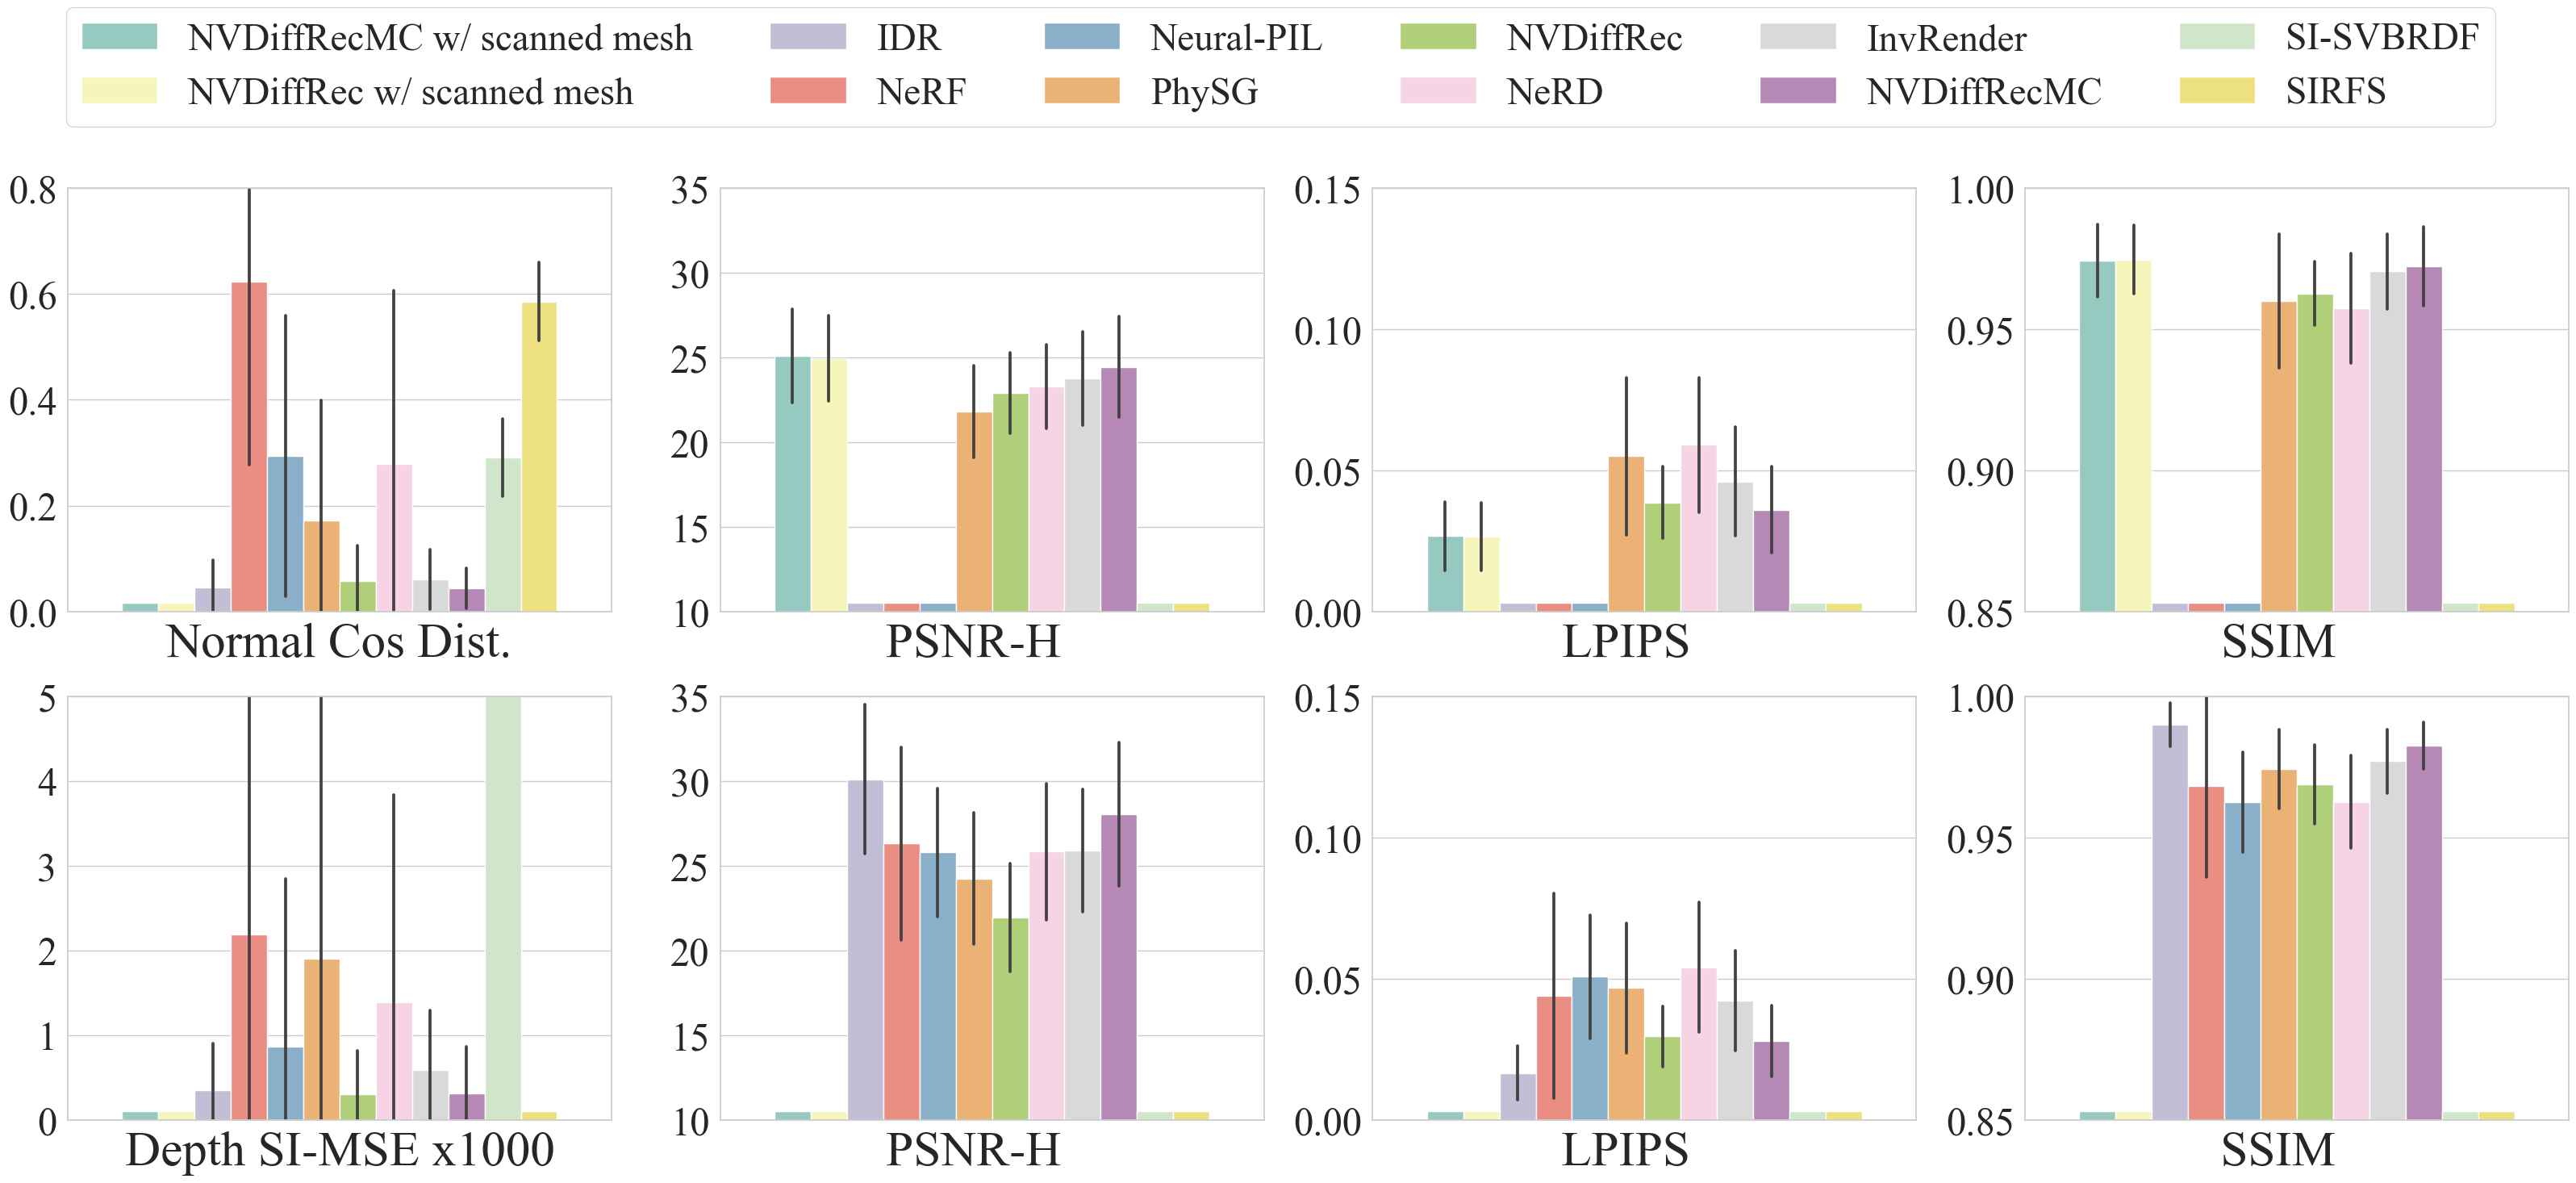

In [14]:
sns.set_theme(style="whitegrid", palette='Set2', font_scale=4, font="Times New Roman")
sns.set_palette(sns.color_palette("Set3", 12))
# Draw a nested barplot by species and sex

row, col = 2, len(panda_metric_list)//2
f, axes = plt.subplots(row, col, figsize=(40, 15))

for i in range(len(panda_metric_list)):
    ax = axes[i//col, i%col]
    metric = panda_metric_list[panda_metric_order[i]]
    sub_df = df.loc[df['metric_name'] == metric]
    origin_metric_name = [x for x in rename_metric_dict if rename_metric_dict[x]==metric.strip()][0]
    g = sns.barplot(
        data=sub_df, 
        x="metric_name", y="metric_score", hue="method_name",
        errorbar="sd", alpha=1, ax=ax
    )
    ax.get_legend().remove()
    d_min, d_max = default_value_min[origin_metric_name], default_value_max[origin_metric_name]
    g.set_ylim(d_min, d_max)
    g.set_xlabel('')
    g.set_ylabel('')
    g.tick_params(axis='y', labelsize=35)
    print()
    
f.align_ylabels(axes)

plt.legend(loc="lower right", bbox_to_anchor=(0.9, 2.3), fontsize=34, ncols=6)

In [12]:
f.savefig("fig.pdf", format="pdf", bbox_inches="tight")
f.savefig("fig.svg", bbox_inches="tight")